# Projet apprentissage stat

**Objectif** : Prédire la variable $\texttt{Walc}$  

Méthodes de régression étudiées
* Régression linéaire
* KNN (pour une régression)
* splines 

source DB : https://www.kaggle.com/uciml/student-alcohol-consumption  
Etude sur les élèves du cours de portugais

**Données d'entrainement** : 500 étudiants  
**Données de test** : 149 étudiants

**Réduction de dimension** : on applique une ACP sur les données d'entrainement pour supprimer des variables quantitatives / on peut appliquer une MCA (Multiple correspondence analysis) qui traite les données qualitatives et quantitatives

In [13]:
rm(list=ls())
library(ISLR)
library(boot)
library (glmnet)
library(glmnetUtils)

Loading required package: Matrix
Loaded glmnet 3.0-2


Attaching package: 'glmnetUtils'

The following objects are masked from 'package:glmnet':

    cv.glmnet, glmnet



# Observation des données

In [14]:
d=read.table("student-por.csv",sep=",",header=TRUE)
n = dim(d)[1]
set.seed(2036125)
d = d[sample(1:n), ]

dim(d)
head(d)
indWalc = which("Walc"==colnames(d))

[1] 649  33

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
489,MS,F,19,U,GT3,T,1,1,at_home,services,...,5,3,1,1,1,3,6,7,9,9
135,GP,F,17,U,LE3,T,2,2,other,other,...,3,4,4,1,3,5,2,13,12,12
184,GP,F,16,U,GT3,T,4,4,health,health,...,4,4,2,1,1,3,0,16,16,17
265,GP,F,17,U,LE3,A,2,2,other,other,...,3,1,2,1,1,1,8,11,9,10
203,GP,F,17,U,GT3,A,3,3,health,other,...,3,3,3,1,3,3,10,12,13,14
229,GP,F,17,R,LE3,T,4,4,services,other,...,5,2,1,1,2,3,6,12,11,11


In [15]:
str(d)

'data.frame':	649 obs. of  33 variables:
 $ school    : Factor w/ 2 levels "GP","MS": 2 1 1 1 1 1 1 2 1 1 ...
 $ sex       : Factor w/ 2 levels "F","M": 1 1 1 1 1 1 2 1 2 2 ...
 $ age       : int  19 17 16 17 17 17 15 17 17 15 ...
 $ address   : Factor w/ 2 levels "R","U": 2 2 2 2 2 1 2 1 2 2 ...
 $ famsize   : Factor w/ 2 levels "GT3","LE3": 1 2 1 2 1 2 1 1 2 2 ...
 $ Pstatus   : Factor w/ 2 levels "A","T": 2 2 2 1 1 2 1 2 1 1 ...
 $ Medu      : int  1 2 4 2 3 4 2 1 3 3 ...
 $ Fedu      : int  1 2 4 2 3 4 2 1 2 2 ...
 $ Mjob      : Factor w/ 5 levels "at_home","health",..: 1 3 2 3 2 4 3 1 3 4 ...
 $ Fjob      : Factor w/ 5 levels "at_home","health",..: 4 3 2 3 3 3 3 1 3 3 ...
 $ reason    : Factor w/ 4 levels "course","home",..: 1 1 4 2 4 3 2 1 4 2 ...
 $ guardian  : Factor w/ 3 levels "father","mother",..: 2 1 2 2 2 2 3 1 2 2 ...
 $ traveltime: int  1 1 1 1 1 1 1 2 1 1 ...
 $ studytime : int  3 1 2 1 2 1 3 1 2 2 ...
 $ failures  : int  1 0 0 1 0 0 0 0 0 0 ...
 $ schoolsup : Factor w/

In [16]:
train = d[1:500,]
test = d[501:n,]

# Regression simple

In [6]:
lm.fit = lm(Walc~.,data=train)
y_pred=predict(lm.fit,test)
mean((y_pred-test$Walc)^2)

[1] 0.9516429

# Regression avec régularisation Elastic Net

In [7]:

x= model.matrix (Walc∼.,train)[,-1]
y= train$Walc

n_alpha = 21
grid.alpha = seq(0,1, length =n_alpha)
grid.lambda =10^ seq (3,-3, length =400)
set.seed(2036125)
cv.out.elastic = cva.glmnet(x,y,alpha = grid.alpha , lambda =grid.lambda,nfolds = 10)

In [8]:
formula
colnames(x)

function (x, ...) 
UseMethod("formula")
<bytecode: 0x0000000027e4f4f8>
<environment: namespace:stats>

[1] "schoolMS"         "sexM"             "age"              "addressU"        
 [5] "famsizeLE3"       "PstatusT"         "Medu"             "Fedu"            
 [9] "Mjobhealth"       "Mjobother"        "Mjobservices"     "Mjobteacher"     
[13] "Fjobhealth"       "Fjobother"        "Fjobservices"     "Fjobteacher"     
[17] "reasonhome"       "reasonother"      "reasonreputation" "guardianmother"  
[21] "guardianother"    "traveltime"       "studytime"        "failures"        
[25] "schoolsupyes"     "famsupyes"        "paidyes"          "activitiesyes"   
[29] "nurseryyes"       "higheryes"        "internetyes"      "romanticyes"     
[33] "famrel"           "freetime"         "goout"            "Dalc"            
[37] "health"           "absences"         "G1"               "G2"              
[41] "G3"

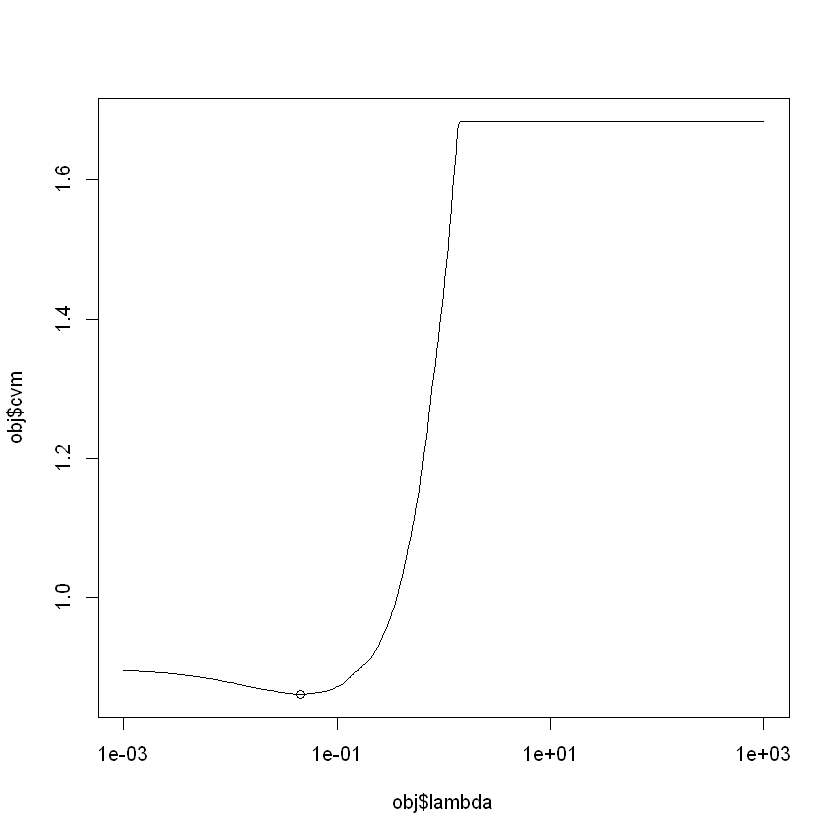

In [9]:
res.err = rep(0, n_alpha)
res.lambda = rep(0, n_alpha)

cpt = 1

for (obj in cv.out.elastic$modlist){
    
    res.err[cpt] = min(obj$cvm)
    truc = which.min(obj$cvm)
    res.lambda[cpt] = obj$lambda.min
    truc2 = obj$nzero[truc]
    cpt = cpt + 1
    if(cpt == 14){
        plot(x=obj$lambda,y=obj$cvm,type="l",log='x')
        points(x = obj$lambda[truc],y = obj$cvm[truc])
    }
    
}

best.index = which.min(res.err)
best.alpha = grid.alpha[best.index]
best.lambda = res.lambda[best.index]
best.err = res.err[best.index]

In [10]:
str(obj)

List of 11
 $ lambda    : num [1:400] 1000 966 933 901 871 ...
 $ cvm       : num [1:400] 1.68 1.68 1.68 1.68 1.68 ...
 $ cvsd      : num [1:400] 0.105 0.105 0.105 0.105 0.105 ...
 $ cvup      : num [1:400] 1.79 1.79 1.79 1.79 1.79 ...
 $ cvlo      : num [1:400] 1.58 1.58 1.58 1.58 1.58 ...
 $ nzero     : Named int [1:400] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "names")= chr [1:400] "s0" "s1" "s2" "s3" ...
 $ call      : language glmnet::cv.glmnet(x = x, y = y, lambda = ..1, nfolds = nfolds, foldid = foldid,      alpha = a)
 $ name      : Named chr "Mean-Squared Error"
  ..- attr(*, "names")= chr "mse"
 $ glmnet.fit:List of 12
  ..$ a0       : Named num [1:400] 2.31 2.31 2.31 2.31 2.31 ...
  .. ..- attr(*, "names")= chr [1:400] "s0" "s1" "s2" "s3" ...
  ..$ beta     :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. ..@ i       : int [1:4006] 35 35 35 35 35 35 35 35 35 35 ...
  .. .. ..@ p       : int [1:401] 0 0 0 0 0 0 0 0 0 0 ...
  .. .. ..@ Dim     : int [1:2] 41 400


In [11]:
best.err 
best.lambda 
best.alpha 
best.index

[1] 0.8605404

[1] 0.04509572

[1] 0.6

[1] 13

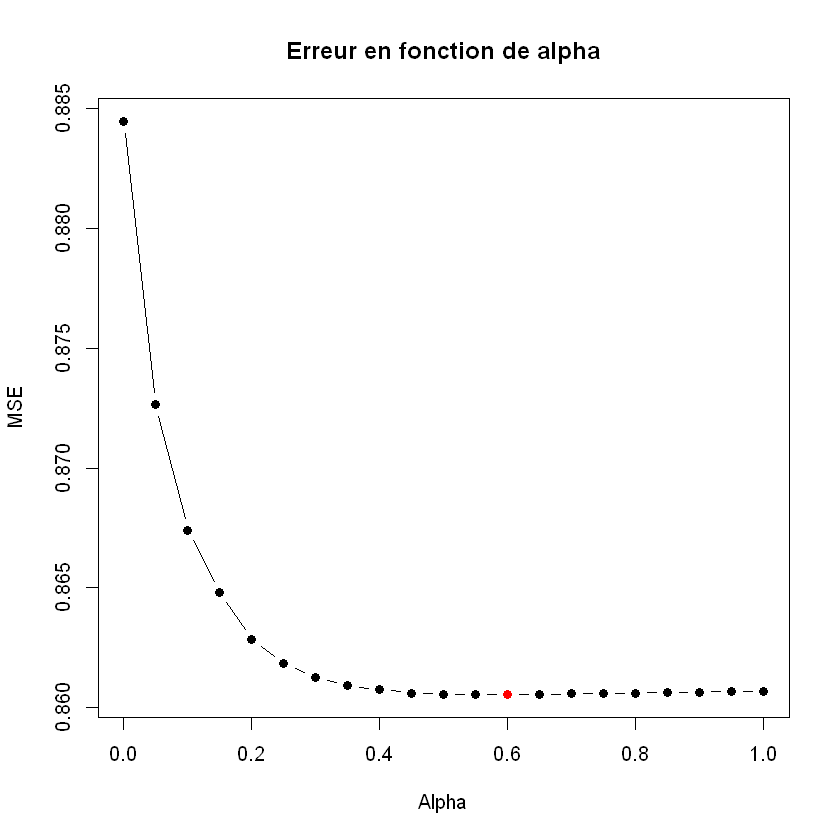

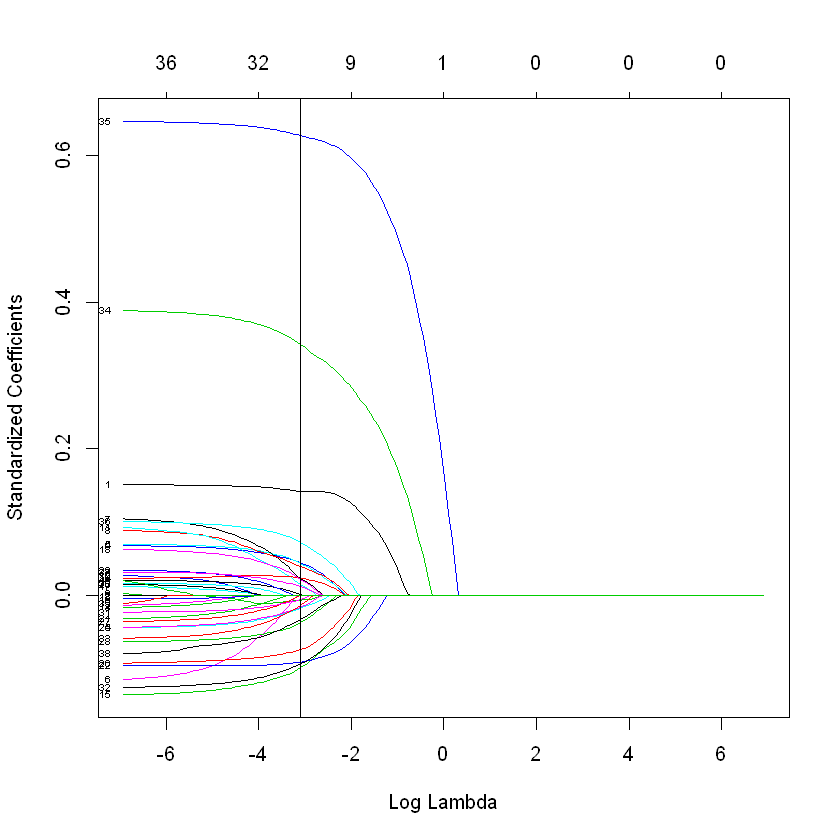

In [12]:

#plot(x=obj$lambda,y=obj$cvm,type="b")
plot(x = grid.alpha, y = res.err, pch=19, type="b", xlab = "Alpha", ylab = "MSE",
    main = "Erreur en fonction de alpha")

points(best.alpha, res.err[best.index], col="red", pch=19)
grid.lambda2 =10^ seq (3,-3, length =200)
x_scaled = scale(x[,-1])
model.elastic_scaled=glmnet(x_scaled,y,alpha =best.alpha , lambda =grid.lambda2, standardized = FALSE )

plot(model.elastic_scaled,xvar="lambda",label=TRUE,ylab ="Standardized Coefficients")
abline(v =log(best.lambda))

In [13]:
rownames(coef(model.elastic_scaled))[35]
rownames(coef(model.elastic_scaled))[34]
rownames(coef(model.elastic_scaled))[1]
length(rownames(coef(model.elastic_scaled)))
rownames(coef(model.elastic_scaled))
truc2

[1] "goout"

[1] "freetime"

[1] "(Intercept)"

[1] 41

[1] "(Intercept)"      "sexM"             "age"              "addressU"        
 [5] "famsizeLE3"       "PstatusT"         "Medu"             "Fedu"            
 [9] "Mjobhealth"       "Mjobother"        "Mjobservices"     "Mjobteacher"     
[13] "Fjobhealth"       "Fjobother"        "Fjobservices"     "Fjobteacher"     
[17] "reasonhome"       "reasonother"      "reasonreputation" "guardianmother"  
[21] "guardianother"    "traveltime"       "studytime"        "failures"        
[25] "schoolsupyes"     "famsupyes"        "paidyes"          "activitiesyes"   
[29] "nurseryyes"       "higheryes"        "internetyes"      "romanticyes"     
[33] "famrel"           "freetime"         "goout"            "Dalc"            
[37] "health"           "absences"         "G1"               "G2"              
[41] "G3"

s303 
  24

In [14]:
model.elastic = glmnet(x,y,alpha = best.lambda, lambda = best.lambda)
xtest = model.matrix (Walc∼.,test)[,-indWalc]
pred.elastic=predict(model.elastic,newx=xtest)
mean((pred.elastic-test$Walc)^2)


[1] 1.280657

In [15]:
result = cbind(pred.elastic,test$Walc)
colnames(result)[1] = "Prediction"
colnames(result)[2] = "True value"
head(result,15)

,Prediction,True value
547,3.723282,1
224,1.530154,1
558,1.593351,1
497,2.244611,2
98,2.137634,1
350,1.749272,2
133,1.551589,2
197,2.415238,3
644,3.102201,2
129,3.530058,5


# Spline (changer)

In [24]:
library (gam)

Loading required package: splines
Loading required package: foreach
Loaded gam 1.16.1



In [25]:
colnames(train)

[1] "school"     "sex"        "age"        "address"    "famsize"   
 [6] "Pstatus"    "Medu"       "Fedu"       "Mjob"       "Fjob"      
[11] "reason"     "guardian"   "traveltime" "studytime"  "failures"  
[16] "schoolsup"  "famsup"     "paid"       "activities" "nursery"   
[21] "higher"     "internet"   "romantic"   "famrel"     "freetime"  
[26] "goout"      "Dalc"       "Walc"       "health"     "absences"  
[31] "G1"         "G2"         "G3"

In [26]:
quali = sapply(train, function(x) is.factor(x))
indWalc2 = which("Walc"==colnames(train[!quali]))
formula = as.formula(paste("Walc~", paste(names(train)[quali], collapse="+"),"+",paste("s(",names(train)[!quali][-indWalc2],", 2)", collapse="+")))

In [27]:
formula

Walc ~ school + sex + address + famsize + Pstatus + Mjob + Fjob + 
    reason + guardian + schoolsup + famsup + paid + activities + 
    nursery + higher + internet + romantic + s(age, 2) + s(Medu, 
    2) + s(Fedu, 2) + s(traveltime, 2) + s(studytime, 2) + s(failures, 
    2) + s(famrel, 2) + s(freetime, 2) + s(goout, 2) + s(Dalc, 
    2) + s(health, 2) + s(absences, 2) + s(G1, 2) + s(G2, 2) + 
    s(G3, 2)

In [22]:
library(gamclass)

In [28]:
gam.m=gam(formula,data=train)
pred.gam=predict(gam.m,test)
length(pred.gam)
length(test$Walc)
mean((pred.gam-test$Walc)^2)
summary(gam.m)

Warning message in model.matrix.default(mt, mf, contrasts):
"non-list contrasts argument ignored"

[1] 149

[1] 149

[1] 0.9919042


Call: gam(formula = formula, data = train)
Deviance Residuals:
     Min       1Q   Median       3Q      Max 
-2.62486 -0.58601 -0.06384  0.51559  2.46923 

(Dispersion Parameter for gaussian family taken to be 0.7449)

    Null Deviance: 839.702 on 499 degrees of freedom
Residual Deviance: 329.985 on 443.0001 degrees of freedom
AIC: 1327.158 

Number of Local Scoring Iterations: 2 

Anova for Parametric Effects
                  Df Sum Sq Mean Sq  F value    Pr(>F)    
school             1   0.58   0.583   0.7832 0.3766560    
sex                1  77.66  77.655 104.2513 < 2.2e-16 ***
address            1   0.00   0.001   0.0015 0.9690561    
famsize            1   3.85   3.850   5.1692 0.0234683 *  
Pstatus            1   4.16   4.162   5.5876 0.0185187 *  
Mjob               4   3.62   0.905   1.2152 0.3035677    
Fjob               4  19.68   4.920   6.6057 3.600e-05 ***
reason             3   5.30   1.767   2.3724 0.0697455 .  
guardian           2   0.36   0.178   0.2395 0.787091

In [29]:
CVgam(formula, data=train, nfold = 10, method = "GCV.Cp",
              printit = TRUE, seed = 2036125)

ERROR: Error in terms.formula(reformulate(term[i])): formule de modèle incorrecte dans ExtractVars


# Méthodes d'arbres (CART)
Le code de base est écrit pour 
* arbres de régression
* bagging
* boosting
* random forest

**Message d'avertissement dans random forest** : comme on a 5 classes, on nous conseille d'utiliser des arbre de classification plutot que de régression.  
Peut être qu'il faut faire pareil avec toutes nos méthodes?  
Essayer de faire du pre processing pour supprimer des aribles inutiles (arbitrairement, faire les moyenne de G1 G2 et G3, ...)

In [50]:
library(tree)

## Arbres de régression

In [18]:
tree.simple = tree(Walc~., data=train)
summary(tree.simple)


Regression tree:
tree(formula = Walc ~ ., data = train)
Variables actually used in tree construction:
[1] "Dalc"      "goout"     "sex"       "Mjob"      "reason"    "studytime"
Number of terminal nodes:  11 
Residual mean deviance:  0.7238 = 354 / 489 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.4040 -0.5756 -0.2105  0.0000  0.4419  3.4240 

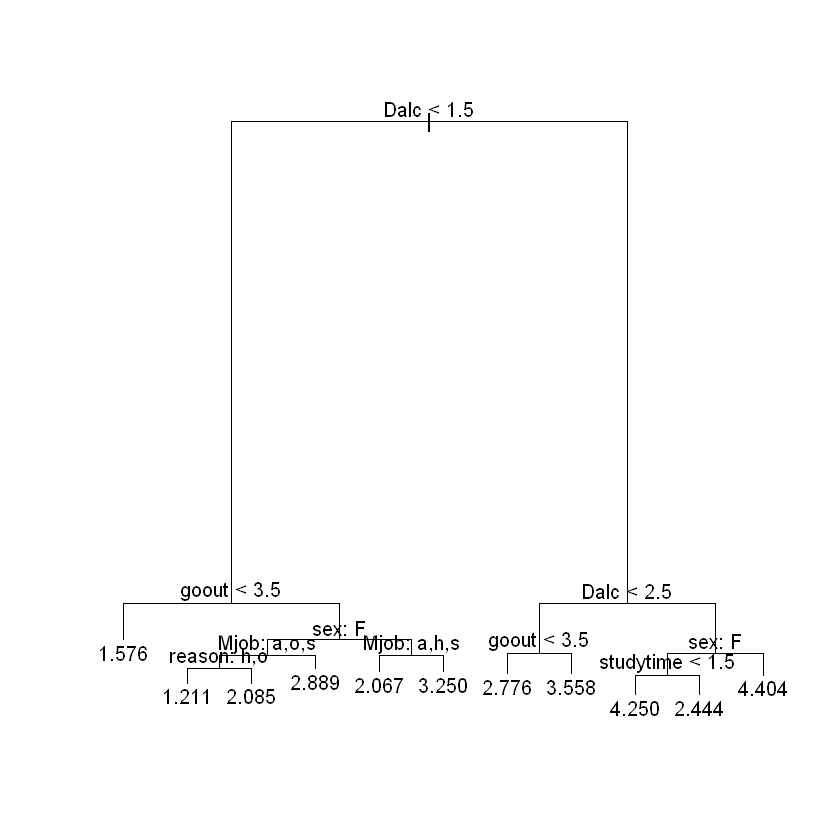

In [20]:
plot(tree.simple)
text(tree.simple, pretty=1)

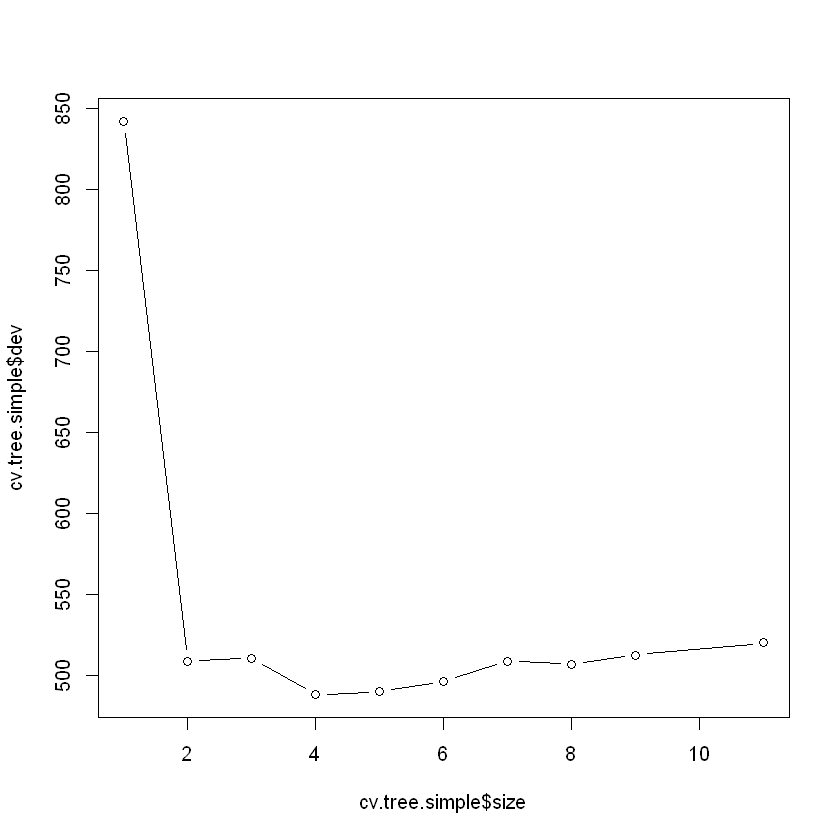

In [22]:
cv.tree.simple = cv.tree(tree.simple)
plot(cv.tree.simple$size ,cv.tree.simple$dev ,type='b')

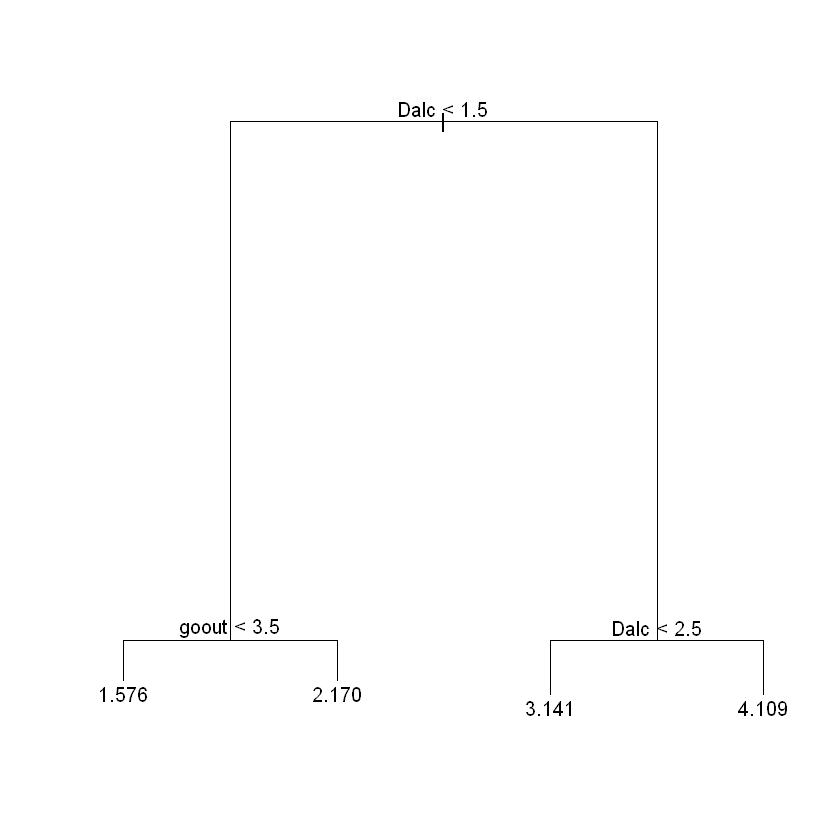

In [34]:
prune.simple = prune.tree(tree.simple ,best=4)
plot(prune.simple)
text(prune.simple, pretty=0) 

Erreur arbre "simple" : 1.229797

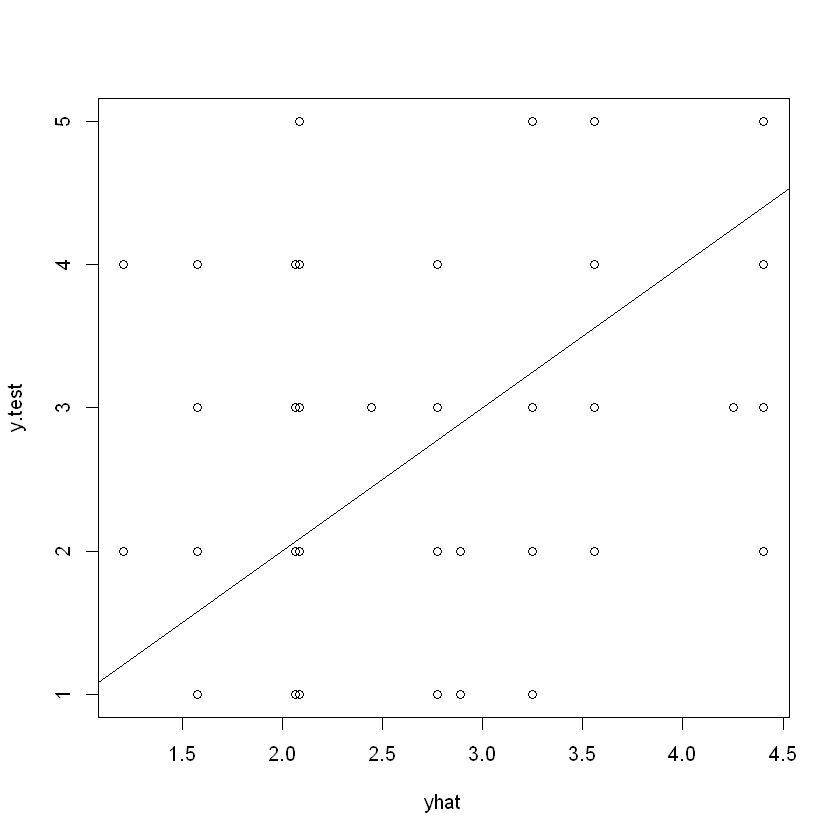

In [35]:
yhat = predict(tree.simple ,newdata = test)
y.test = test[,indWalc]
plot(yhat ,y.test)
abline(0,1)
cat('Erreur arbre "simple" :', mean((yhat -y.test)^2)) 

Erreur arbre élagué : 1.143467

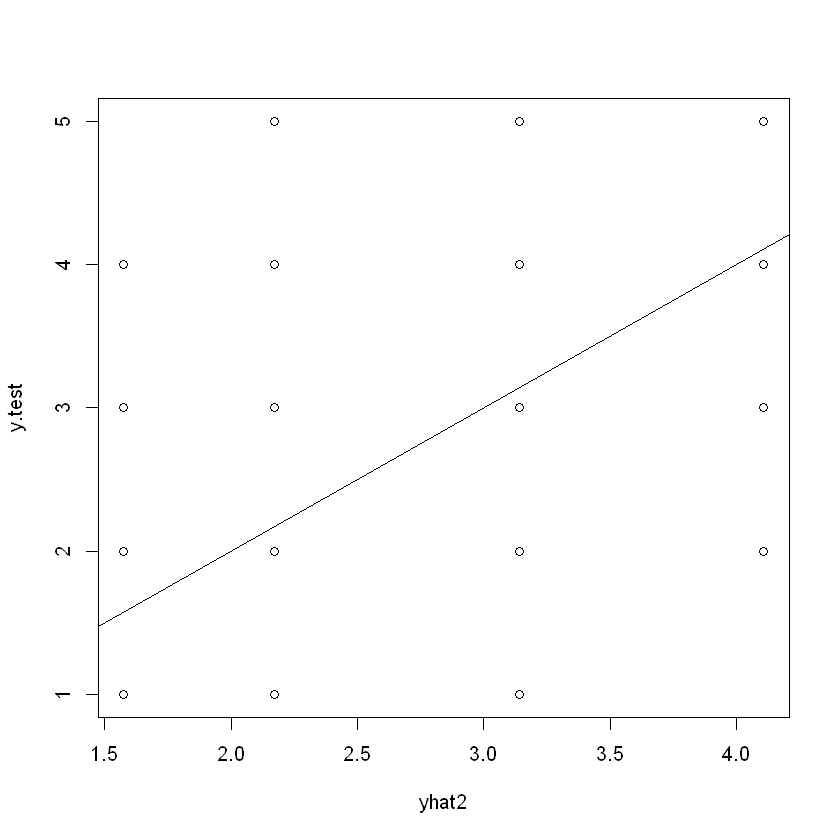

In [36]:
yhat2 = predict(prune.simple ,newdata = test)
plot(yhat2 ,y.test)
abline(0,1)
cat('Erreur arbre élagué :', mean((yhat2 -y.test)^2))

## Random Forest et Bagging

In [37]:
library(randomForest)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.


In [41]:
set.seed(2036125)

# Bagging
bag.Walc = randomForest(Walc~., data=train, mtry=32,importance=TRUE)
bag.Walc

Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"


Call:
 randomForest(formula = Walc ~ ., data = train, mtry = 32, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 32

          Mean of squared residuals: 0.8264532
                    % Var explained: 50.79

[1] 1.168372

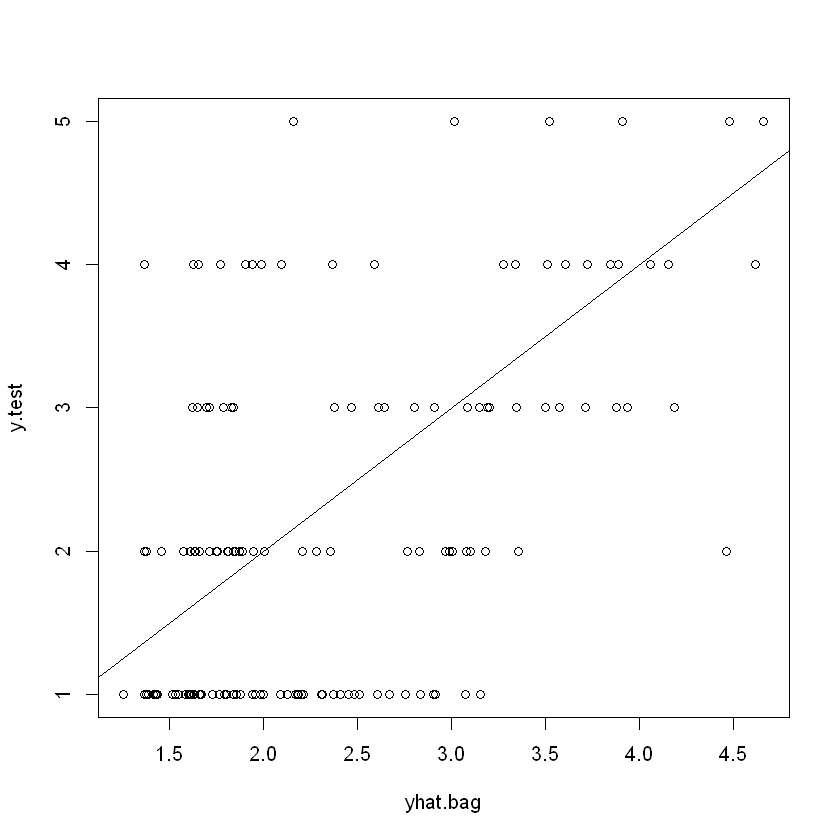

In [42]:
yhat.bag = predict(bag.Walc, newdata=test)
plot(yhat.bag , y.test)
abline(0,1)
mean((yhat.bag - y.test)^2)

In [43]:
set.seed(2036125)

# Random Forest
rf.Walc = randomForest(Walc~., data=train, mtry=11, importance=TRUE)
yhat.rf = predict(rf.Walc, newdata=test)
mean((yhat.rf - y.test)^2) 

Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"

[1] 1.125701

## Boosting
* Essayer de faire varier les valeurs de *interaction.depth* et de *shrinkage* (qui vaut 0.2 par défaut)

In [44]:
library(gbm)

Loaded gbm 2.1.5


In [46]:
set.seed(2036125)
boost.Walc = gbm(Walc~., data=train, distribution= "gaussian",n.trees=5000,interaction.depth=4)

,var,rel.inf
Dalc,Dalc,19.7529511
goout,goout,7.4155251
Mjob,Mjob,7.1092383
G2,G2,4.9338933
Fjob,Fjob,4.6953839
G3,G3,4.3495772
absences,absences,4.2043739
reason,reason,4.0499427
G1,G1,3.8855514
health,health,3.7660834


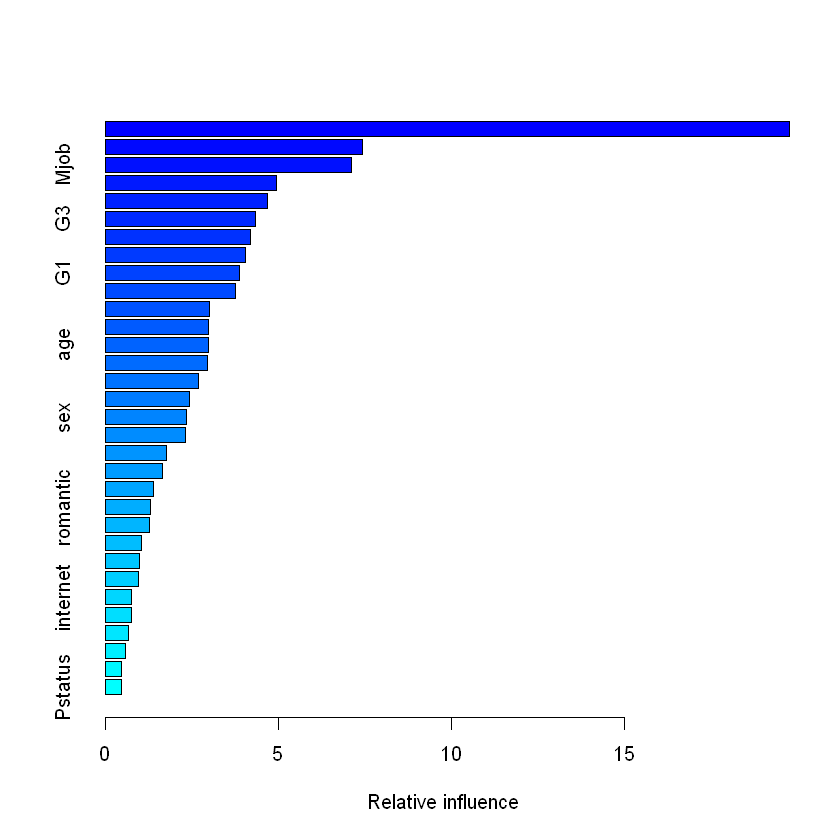

In [47]:
summary(boost.Walc)

In [49]:
yhat.boost = predict(boost.Walc, newdata = test, n.trees=5000)
mean((yhat.boost-y.test)^2) 

[1] 1.553224